In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/train.csv')


In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [5]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

In [6]:
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns),
    ]
)

In [8]:
X = preprocessor.fit_transform(df)

In [172]:
df[[categorical_columns[0]]].values

array([['Private'],
       ['Private'],
       ['Private'],
       ...,
       ['Private'],
       ['Private'],
       ['Private']], dtype=object)

In [9]:
metadata = []
for col in categorical_columns:
  data = df[[col]].values
  ohe = OneHotEncoder(sparse_output=False)
  ohe.fit(data)
  categories = len(ohe.categories_[0])
  metadata.append(categories)

In [10]:
metadata = np.array(metadata)
indices = np.zeros_like(metadata)
indices[1:] = metadata[:-1]
indices = indices.cumsum()

In [11]:
num_discrete_columns = len(metadata)
num_discrete_columns_options = sum(metadata)

In [12]:
probabilities = np.zeros((num_discrete_columns, max(metadata)))
def calculate_probabilities(data):
  start_ind = 0
  for dis_col,ind in enumerate(metadata):
    tmp = np.sum(data[:, start_ind:start_ind+ind], axis=0)
    probabilities[dis_col,:ind] = tmp/np.sum(tmp)
    start_ind += ind
calculate_probabilities(X)

In [13]:
def random_choice_prob_index(idx):
    a = probabilities[idx]
    r = np.expand_dims(np.random.rand(a.shape[0]), axis=1)
    return (a.cumsum(axis=1) > r).argmax(axis=1)
print(random_choice_prob_index([6,7]))

[ 0 38]


In [14]:
def datasample(batch):
  idx_cols = np.random.choice(np.arange(num_discrete_columns), batch)
  vec1 = np.zeros((batch, num_discrete_columns_options), dtype='float32')
  mask1 = np.zeros((batch, num_discrete_columns), dtype='float32')
  mask1[np.arange(batch), idx_cols] = 1
  opt1prime = random_choice_prob_index(idx_cols)
  opt1 = indices[idx_cols] + opt1prime
  #print(opt1)
  vec1[np.arange(batch), opt1] = 1

  return vec1, mask1, idx_cols, opt1prime

In [16]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
noise_dim = 128
generator = Generator(input_dim=(noise_dim+X.shape[1]), output_dim=X.shape[1]).to(device)
discriminator = Discriminator(input_dim=X.shape[1]).to(device)

In [20]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-4)

In [21]:
def apply_activate(data):
  data_t = []
  start_ind = 0
  for ind in metadata:
    # print(ind)
    # print(F.softmax(data[:,start_ind:start_ind+ind],dim=1).shape)
    data_t.append(F.softmax(data[:,start_ind:start_ind+ind],dim=1))
    start_ind += ind
  return torch.cat(data_t, dim=1)

In [22]:
epochs = 500
batch_size = 32
steps_per_epoch = max(len(X) // batch_size, 1)

In [26]:
class Sampler:
    def __init__(self, data, output_info):
        self.data = data
        self.model = []
        self.n = len(data)
        st = 0
        for item in output_info:
                ed = st + item
                tmp = []
                for j in range(item):
                    tmp.append(np.nonzero(data[:, st + j])[0])

                self.model.append(tmp)
                st = ed

    def sample(self, n, col, opt):
        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))
        #print(idx)
        return self.data[idx]

In [27]:
sampler = Sampler(X,metadata)

In [28]:
G_losses = []
D_losses = []

for epoch in range(epochs):
  for steps in range(steps_per_epoch):
      noise = torch.randn(batch_size, noise_dim,dtype=torch.float32).to(device)
      condvec = datasample(batch_size)
      c1, m1, col, opt = condvec
      c1 = torch.from_numpy(c1).to(device)
      m1 = torch.from_numpy(m1).to(device)
      #print(c1.shape)
      noisez = torch.cat([noise, c1], dim=1)

      perm = np.arange(batch_size)
      np.random.shuffle(perm)
      real_data = sampler.sample(batch_size,col[perm],opt[perm])
      optimizer_discriminator.zero_grad()

      real_labels = torch.ones(batch_size, 1).to(device)
      output_real = discriminator(torch.tensor(real_data,dtype=torch.float32).to(device))
      loss_real = criterion(output_real, real_labels)

      fake = generator(noisez)
      fakeact = apply_activate(fake)

      output_fake = discriminator(fakeact)
      fake_labels = torch.zeros(batch_size, 1).to(device)
      loss_fake = criterion(output_fake, fake_labels)

      # Combine Losses for discriminator and Update
      loss_disc = loss_real + loss_fake
      loss_disc.backward(retain_graph=True)
      optimizer_discriminator.step()

      optimizer_generator.zero_grad()
      output = discriminator(fakeact)
      loss_gen = criterion(output, real_labels)
      loss_gen.backward()
      optimizer_generator.step()

      G_losses.append(loss_gen.item())
      D_losses.append(loss_disc.item())

      if steps % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, epochs, steps, steps_per_epoch, loss_disc.item(), loss_gen.item(), output_real.mean().item(), output_fake.mean().item(), output.mean().item()))


Streaming output truncated to the last 5000 lines.
[321/500][600/1373]	Loss_D: 0.1721	Loss_G: 2.3814	D(x): 0.9717	D(G(z)): 0.0970 / 0.0972
[321/500][650/1373]	Loss_D: 0.2353	Loss_G: 2.3825	D(x): 0.9472	D(G(z)): 0.1061 / 0.1043
[321/500][700/1373]	Loss_D: 0.4476	Loss_G: 2.5253	D(x): 0.8609	D(G(z)): 0.0916 / 0.0916
[321/500][750/1373]	Loss_D: 0.5547	Loss_G: 2.5801	D(x): 0.8274	D(G(z)): 0.0819 / 0.0832
[321/500][800/1373]	Loss_D: 0.5001	Loss_G: 2.6376	D(x): 0.8542	D(G(z)): 0.0765 / 0.0758
[321/500][850/1373]	Loss_D: 0.3189	Loss_G: 2.4595	D(x): 0.9153	D(G(z)): 0.0928 / 0.0917
[321/500][900/1373]	Loss_D: 0.2905	Loss_G: 2.5990	D(x): 0.9166	D(G(z)): 0.0777 / 0.0769
[321/500][950/1373]	Loss_D: 0.2968	Loss_G: 2.3991	D(x): 0.9231	D(G(z)): 0.0967 / 0.0966
[321/500][1000/1373]	Loss_D: 0.4899	Loss_G: 2.4982	D(x): 0.8535	D(G(z)): 0.0925 / 0.0913
[321/500][1050/1373]	Loss_D: 0.4624	Loss_G: 2.4620	D(x): 0.8586	D(G(z)): 0.0877 / 0.0876
[321/500][1100/1373]	Loss_D: 0.2438	Loss_G: 2.6274	D(x): 0.9416	D(G

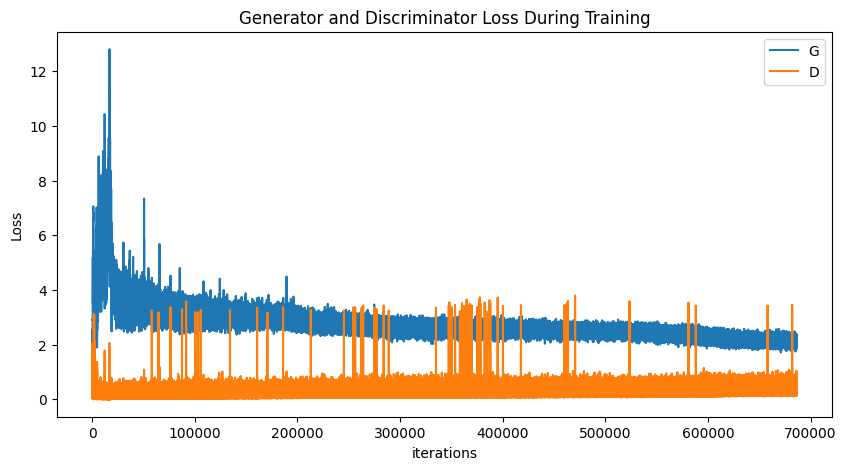

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [2]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
